# Hyperparameter Optimisation Lab - 0

This notebook is a gentle introduction to hyperparameter tuning. In it we will familiarise ourselves with a simple convolutional neural network model that we will be fitting against a subset of [MNIST](http://yann.lecun.com/exdb/mnist/).

We start by importing all the necessary libraries for this tutorial.  We also set the random seed for the purposes of reproducibility.

In [1]:
import torch
import time
import datetime
import os
import torchsummary
import math 

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datetime import timedelta

# This degrades the performance but enforces reproducibility.
torch.use_deterministic_algorithms(True)

# Note: This notebook hasn't been fully tested with GPU backends.
# If you are using GPU-acceleration you may also have to enable the following lines:
#
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
#torch.cuda.manual_seed_all(1234)

# Make sure our tests are reproducible
torch.manual_seed(1234)
np.random.seed(1234)

if torch.cuda.is_available():
  os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
  print("CUDA available. Using GPU acceleration.\n")
  device = "cuda"
else:
  print("CUDA is NOT available. Using CPU for training.\n")
  device = "cpu"

CUDA is NOT available. Using CPU for training.



The next Python function loads the MNIST data set, shuffles the observations, and creates a training, validation, and test splits. It also creates Torch tensors using the resulting subsets so that we can feed this data directly to the CNN network later.

In [2]:
def load_mnist(device = "cpu", data_path = "data", train_fraction = 0.8, verbose = True):

    assert 0.0 <= train_fraction <= 1.0
    
    train_X = np.load(os.path.join(data_path, "train_X.npy"))
    train_y = np.load(os.path.join(data_path, "train_y.npy"))
    test_X = np.load(os.path.join(data_path, "test_X.npy"))
    test_y = np.load(os.path.join(data_path, "test_y.npy"))
                     
    indices = np.random.permutation(train_X.shape[0])
    training_size = int(train_X.shape[0] * train_fraction)
    training_idx, valid_idx = indices[:training_size], indices[training_size:]
    train_X, valid_X = train_X[training_idx,:], train_X[valid_idx,:]
    train_y, valid_y = train_y[training_idx], train_y[valid_idx]

    train_X = torch.tensor(train_X, device=device).unsqueeze(dim=1).float()
    train_y = torch.tensor(train_y, device=device)
    valid_X = torch.tensor(valid_X, device=device).unsqueeze(dim=1).float()
    valid_y = torch.tensor(valid_y, device=device)    
    test_X = torch.tensor(test_X, device=device).unsqueeze(dim=1).float()
    test_y = torch.tensor(test_y, device=device)
    
    if verbose:
        print("train_X size : ", train_X.shape)
        print("train_y size : ", train_y.shape)
        print("valid_X size : ", valid_X.shape)
        print("valid_y size : ", valid_y.shape)
        print("test_X size  : ", test_X.shape)
        print("test_y size  : ", test_y.shape)
        
    return train_X, train_y, valid_X, valid_y, test_X, test_y

MNIST contains 70,000 samples (60,000 in the training and 10,000 in test subsets). Our *load_mnist()* function changes this to 48,000 in training, 12,000 in validation, and 10,000 in test. This, however, is still quite a lot of data. Given the time constraint of the workshop we'll further trim down the training subset to 20,000 samples in total.

In [3]:
train_X, train_y, valid_X, valid_y, test_X, test_y = load_mnist(device, verbose=False)

# Using only the first 20,000 training samples to save time at the workshop.
# Comment out to use the complete MNIS training set
train_X = train_X[:20000]
train_y = train_y[:20000]

We don't need to worry about class imbalance too much as the data has already been shuffled. We'll inspect the class distribution just in case to make sure that all 10 classes (digits 0-9) are relatively equally represented.

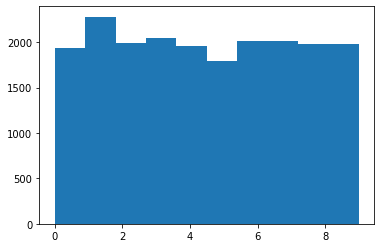

In [4]:
import matplotlib.pyplot as plt

plt.hist(train_y.numpy(), bins=10)
plt.show()

We now define the architecture of the neural network that we'll be using for classifying the MNIST images. In this tutorial we'll use a [Convolutional Neural Network (CNN)](https://www.dominodatalab.com/blog/gpu-accelerated-convolutional-neural-networks-with-pytorch) via PyTorch. The feature extraction (or feature learning) part of the network employs a series of convolutional and pooling layers. 

* Each **convolutional layer** applies a filter, which is convolved with the input to create an activation map. The filter is slid over the image (both horizontally and vertically) and an output scalar is calculated for each spatial position. If the image contains data about colour, the typical approach is to process each colour channel separately, producing a tensor instead of a simple 2D matrix. 

* Convolutional layers generally preserve the dimensionality of the input. This may be problematic, because the same feature (e.g. an edge or a straight line) if present in different places in the image results in different feature maps. **Pooling layers** is what CNNs use to address this challenge. These layers downsample the image to lower resolutions in a way that also preserves the features present in the feature map.

![Architecture of a CNN](images/cnn.png "CNN architecture")

After the relevant features have been extracted, the final layer is flattened so that all features can be fed to the second component of the CNN - **a fully connected feedforward network**. This part of the network is responsible for performing the actual classification, and its number of outputs corresponds to the number of classes in the dataset (10 for MNIST). The outputs are typically evaluated after a *softmax* function, which is used to squash the raw scores into normalised values that add up to one. This is a standard configuration for a classical feedforward network tasked with classification problems.

In [5]:
class Net(nn.Module):
    
    def __init__(self, activ):
        
        super().__init__()
        
        self.activ = activ
        
        self.conv1 = nn.Conv2d(in_channels=1,              
                               out_channels=16,            
                               kernel_size=5,             
                               stride=1,                   
                               padding=2)                            
                
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)    
        self.pool2 = nn.MaxPool2d(2)               
        
        self.fc = nn.Linear(32 * 7 * 7, 10)
        
        self.softmax = F.log_softmax

    def forward(self, x):
        # Our network has two pairs of convolutional/pooling layers for feature extraction
        # Pair 1
        x = self.conv1(x)
        x = self.activ(x)
        x = self.pool1(x)
        
        # Pair 2
        x = self.conv2(x)
        x = self.activ(x)
        x = self.pool2(x)

        # Then the fully connected layer...
        x = x.view(x.size(0), -1)   
        x = self.fc(x)
    
        #... and the softmax
        output = self.softmax(x, dim=1)
        
        return output
    
    def summary(self, input_size=(1, 28, 28)):
        # Torch-summary provides information similar to Tensorflow's model.summary() API to view the visualization of the model.
        # We'll use it to print information about the architecture and number of parameters of our network.
        torchsummary.summary(self, input_size = input_size)
        
    def reset(self):
        # This re-initializes the weights of the network without having to reinstate it
        # We'll use it for performance and reproducibility purposes
        for layer in self.children():
           if hasattr(layer, "reset_parameters"):
               layer.reset_parameters()


Now let's build a training loop / method.

In [6]:
def train(net, batch_size, loss_crierion, optimizer, train_X, train_y, max_epochs = 1, verbose = True, iterations = 1000):
    
    loss_hist = []

    samples_per_epoch = train_X.shape[0]
    
    # Loop over the number of epochs
    for epoch in range(max_epochs):

        # Loop over the number of mini-batched in each epoch
        for index in range(0, samples_per_epoch, batch_size):

            # Get the current mini-batch
            images = train_X[index:index + batch_size, :, :]
            labels = train_y[index:index + batch_size,]

            # Set all gradients to zero
            optimizer.zero_grad()

            # Do a forward pass & calculate the loss
            out = net(images)
            loss = loss_crierion(out, labels)
            loss_hist.append(loss.item())

            # Calculate the gradients via backpropagation
            loss.backward()
            # Update the weight matrices
            optimizer.step()
            
            if verbose and (index % iterations == 0):
                 print("Epochs [{:d}/{:d}], Samples[{:d}/{:d}], Loss: {:.4f}".format(epoch + 1, max_epochs, index + iterations, samples_per_epoch, loss))
                    
    return loss_hist

Finally, let's create a function to calculate the accuracy using a holdout set (validation or test).

In [7]:
def test(net, test_X, test_y):
    
    with torch.no_grad():
        # Do a forward pass using the holdout data
        out = net.forward(test_X)
        # Convert the output probabilities to a one-hot vector
        pred = torch.argmax(out, 1)
        # Compare to ground truth
        correct = pred.eq(test_y).sum()
    
    # Caclualte the accuracy
    accuracy = correct / test_X.shape[0]
    
    return accuracy

### Task 1 - Test the network

In this simple task you'll instantiate the CNN and run it with a set of manually selected hyperparameters. This is simply to ensure that our network functions properly and to help you familiarise yourself with the parameters that we'll be optimising.

Use the cell below to create an instance of the network named *net*, which uses ReLU as its transfer function. Then print the Layer/Output/Params information of the network using its *summary()* method.

In [8]:
# Build network
activ = F.relu

net = Net(activ = activ)
#net.to(device)
net.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]          12,832
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.11
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


Let's set some random hyperparameters and confirm that the network executes properly. It is generally a good idea to constrain the epochs to 1 to avoid long training times.

In [9]:
# Set Hyperparameters
batch_size = 100
learning_rate = 0.001
momentum = 1.0
max_epochs = 1

The final two bits of the puzzle are the loss function that the network will optimise and the optimiser used for adjusting the network's weights. As this is a classification problem we will use a criterion that computes the cross entropy loss. As for the optimiser, we'll start with the most simple option - stochastic gradient descent.

In [10]:
loss_crierion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)


Now let's call the *train()* method, passing the network, batch size, loss criterion, optimiser, and training data (X and y) as arguments. 

In [11]:
train(net, batch_size, loss_crierion, optimizer, train_X, train_y);

Epochs [1/1], Samples[1000/20000], Loss: 17.7437
Epochs [1/1], Samples[2000/20000], Loss: 2.0174
Epochs [1/1], Samples[3000/20000], Loss: 1.1164
Epochs [1/1], Samples[4000/20000], Loss: 1.1852
Epochs [1/1], Samples[5000/20000], Loss: 0.8967
Epochs [1/1], Samples[6000/20000], Loss: 1.0021
Epochs [1/1], Samples[7000/20000], Loss: 0.9828
Epochs [1/1], Samples[8000/20000], Loss: 0.7398
Epochs [1/1], Samples[9000/20000], Loss: 0.7564
Epochs [1/1], Samples[10000/20000], Loss: 1.1834
Epochs [1/1], Samples[11000/20000], Loss: 0.8022
Epochs [1/1], Samples[12000/20000], Loss: 1.0543
Epochs [1/1], Samples[13000/20000], Loss: 1.0910
Epochs [1/1], Samples[14000/20000], Loss: 1.4456
Epochs [1/1], Samples[15000/20000], Loss: 1.3798
Epochs [1/1], Samples[16000/20000], Loss: 1.3883
Epochs [1/1], Samples[17000/20000], Loss: 1.3792
Epochs [1/1], Samples[18000/20000], Loss: 1.3195
Epochs [1/1], Samples[19000/20000], Loss: 1.1648
Epochs [1/1], Samples[20000/20000], Loss: 1.7848


If you've picked reasonable hyperparameters you should see the training loss decreasing with each iteration.

Finally, let's test the performance of the network on the validation set (*valid_X* and *valid_y*)

In [12]:
# Call test()
print("Testing...")
acc = test(net, valid_X, valid_y)
print("Validation accuracy: {:.4f}".format(acc))

Testing...
Validation accuracy: 0.5162


### Task 2

Now that we have a working network let's proceed with some rudimentary hyperparameter tuning.

Let's start by defining ranges for the individual parameters. We'll put everything in a dictionary with the parameter names acting as keys and their respective test values stored in corresponding lists. We'll also add the loss and the optimiser as fixed parameters in case we want to try something different later on.

Here is the definition of the parameters dictionary:


In [13]:
params = {"learning_rate": [0.1, 0.01, 0.001, 0.0001],
          "batch_size"   : [10, 20, 50, 100],
          "momentum"     : [0.9]}

params["optimizer"] = [optim.SGD]
params["loss"] = [nn.CrossEntropyLoss()]

Our next task is to create a function *get_param_grid(params)*, which accepts the parameters dictionary and generates all possible parameter combinations. 
The function should return a list of dictionaries, each dictionary representing a single experiment. For example the first element of the list could be:

```
{'learning_rate': 0.1,
 'batch_size': 10,
 'momentum': 0.9,
 'optimizer': torch.optim.sgd.SGD,
 'loss': CrossEntropyLoss()}
```

The second element could be

```
{'learning_rate': 0.1,
 'batch_size': 20,
 'momentum': 0.9,
 'optimizer': torch.optim.sgd.SGD,
 'loss': CrossEntropyLoss()}
```

 and so on.

In [14]:
import itertools

def get_param_grid(params):
    
    keys, values = zip(*params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    return experiments

Let's verify that your *get_param_grid(params)* implementation works correctly.

In [15]:
experiments = get_param_grid(params)

assert len(experiments) == math.prod(map(len, params.values())), "It doesn't look like get_param_grid() generated the correct number of experiments"

We can also see a list of all experiemnts (or hyperparameter values) that we need to try.

In [16]:
print(*experiments,sep='\n')

{'learning_rate': 0.1, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.1, 'batch_size': 20, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.1, 'batch_size': 50, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.1, 'batch_size': 100, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.01, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.01, 'batch_size': 20, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.01, 'batch_size': 50, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.01, 'batch_size': 100, 'momentum': 0.9, 'optimizer': <class 'torch

We now define a function to facilitate the execution of experiments. The function below, aptly named *run_experiment* takes an experiment from the list of experiments, a training set, and a holdout set. It then unpacks the hyperparameters, resets the network, calls *train()* with the specificed hyperparameters, and finally calculates the accuracy on the holdout set.

In [17]:
def run_experiment(exp, net, train_X, train_y, test_X, test_y):
    
    start_time = time.time()
    
    if (exp["optimizer"] == optim.SGD):
        optimizer = optim.SGD(net.parameters(), lr=exp["learning_rate"], momentum=exp["momentum"])
    else:
        optimizer = exp["optimizer"](net.parameters(), lr=exp["learning_rate"])

    loss_crierion = exp["loss"]
    
    # Make sure we aren't training an already trained network
    net.reset()
    
    loss_hist = train(net, exp["batch_size"], loss_crierion, optimizer, train_X, train_y, verbose=False)
    
    # Accuracy on holdout
    acc = test(net, test_X, test_y)    
    
    # How long did training take?
    elapsed_time = time.time() - start_time
    
    return loss_hist, acc, elapsed_time

Below we also set up a final helper function, which can traverse a list of experiments and their respecitve validation accuracy, and pick the best performing combination of hyperparameters.

In [18]:
def get_best_run(acc_hist, experiments, verbose=False):
    
    highest_acc = max(acc_hist)
    highest_acc_idx = acc_hist.index(highest_acc)
        
    return highest_acc, experiments[highest_acc_idx]

Here we have the main training loop. It will perform a comprehensive run of all experiments in the *experiments* list and pick the best performing combination using the *get_best_run()* function. The loop also calculates the ETA for the complete grid search as it progresses through the individual experiments.

In [19]:
exp_counter = 0
acc_hist = []

runtime = 0

for exp in experiments:   

    exp_counter += 1
 
    print("Exp {:d}/{:d}: ".format(exp_counter, len(experiments)), exp, end=" ")
    loss_hist, acc, elapsed_time = run_experiment(exp, net, train_X, train_y, test_X, test_y)
    acc_hist.append(acc)
    
    runtime += elapsed_time
    elapsed_time = str(timedelta(seconds = elapsed_time)).split(".")[0]
    eta = str(timedelta(seconds = (runtime / exp_counter) * (len(experiments) - exp_counter))).split(".")[0]

    print("Validation acc: {:.2f}".format(acc), end=" ")   
    print("Runtime: {} ETA: {}".format(elapsed_time, eta))
    
highest_acc, best_params = get_best_run(acc_hist, experiments)
print("\nHighest validation acc: {:.2f}".format(highest_acc))
print("Best parameters       :", best_params)
print("Total runtime         : ",  runtime)

Exp 1/16:  {'learning_rate': 0.1, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.10 Runtime: 0:00:28 ETA: 0:07:03
Exp 2/16:  {'learning_rate': 0.1, 'batch_size': 20, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.10 Runtime: 0:00:15 ETA: 0:05:06
Exp 3/16:  {'learning_rate': 0.1, 'batch_size': 50, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.10 Runtime: 0:00:13 ETA: 0:04:06
Exp 4/16:  {'learning_rate': 0.1, 'batch_size': 100, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.10 Runtime: 0:00:10 ETA: 0:03:23
Exp 5/16:  {'learning_rate': 0.01, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.10 Runtime: 0:00:24 ETA: 0:03:23
Exp 6/16:  {'learning_rate': 0.01, 'ba

### Task 3


In this taks we will expand the parameter space by adding more values to *momentum* and introducing a second optimiser *optim.Adagrad*.

Let's first see how this impacts the number of parameters we need to perform.

In [20]:
params = {"learning_rate": [0.1, 0.01, 0.001, 0.0001],
          "batch_size"   : [10, 20, 50, 100],
          "momentum"     : [0.5, 0.9, 1.0]}

params["optimizer"] = [optim.SGD, optim.Adagrad]
params["loss"] = [nn.CrossEntropyLoss()]

experiments = get_param_grid(params)

len(experiments)

96

This appears to be a substantial number of experiments. We need a different strategy if we don't want to wait too long for an exhaustive search of the highest validation accuracy. One simple idea is to employ random search.

Your task is to write a function *get_random_grid(params, n)*, which takes the parameters dictionary and an integer *n* and produces *n* randomly generated experiments for our training loop to try.

In [21]:
import random

def get_random_grid(params, n):
    
    experiments = get_param_grid(params)
    experiments = random.choices(experiments, k=n)
    
    return experiments

OK, now let's construct our *experiments* list. We'll use the same number of experiments as before (16), but this time the combinations of parameters have been randomly chosen.

In [22]:
experiments = get_random_grid(params, 16)

Let's look at the experiments that we'll be trying.

In [23]:
print(*experiments,sep='\n')

{'learning_rate': 0.01, 'batch_size': 100, 'momentum': 1.0, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.001, 'batch_size': 50, 'momentum': 0.5, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.0001, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.01, 'batch_size': 10, 'momentum': 0.5, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.001, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.0001, 'batch_size': 100, 'momentum': 0.9, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.001, 'batch_size': 100, 'momentum': 1.0, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()}
{'learning_rate': 0.0001, 'batch_size': 20, 'mome

Now let's run the training loop as see how our random search perfoms compared to the naive grid search.

In [ ]:
exp_counter = 0
acc_hist = []

runtime = 0

for exp in experiments:   

    exp_counter += 1
 
    print("Exp {:d}/{:d}: ".format(exp_counter, len(experiments)), exp, end=" ")
    loss_hist, acc, elapsed_time = run_experiment(exp, net, train_X, train_y, valid_X, valid_y)
    acc_hist.append(acc)
    
    runtime += elapsed_time
    elapsed_time = str(timedelta(seconds = elapsed_time)).split(".")[0]
    eta = str(timedelta(seconds = (runtime / exp_counter) * (len(experiments) - exp_counter))).split(".")[0]

    print("Validation acc: {:.2f}".format(acc), end=" ")   
    print("Runtime: {} ETA: {}".format(elapsed_time, eta))
    
highest_acc, best_params = get_best_run(acc_hist, experiments)
print("\nHighest validation acc: {:.2f}".format(highest_acc))
print("Best parameters       :", best_params)
print("Total runtime         : ",  runtime)

Exp 1/16:  {'learning_rate': 0.01, 'batch_size': 100, 'momentum': 1.0, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.10 Runtime: 0:00:12 ETA: 0:03:09
Exp 2/16:  {'learning_rate': 0.001, 'batch_size': 50, 'momentum': 0.5, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.94 Runtime: 0:00:13 ETA: 0:03:06
Exp 3/16:  {'learning_rate': 0.0001, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'loss': CrossEntropyLoss()} Validation acc: 0.69 Runtime: 0:00:23 ETA: 0:03:39
Exp 4/16:  {'learning_rate': 0.01, 'batch_size': 10, 'momentum': 0.5, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'loss': CrossEntropyLoss()} Validation acc: 0.96 Runtime: 0:00:26 ETA: 0:03:50
Exp 5/16:  {'learning_rate': 0.001, 'batch_size': 10, 'momentum': 0.9, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss': CrossEntropyLoss()} Validation acc: 0.94 Runtime: 0:00:25 ETA: 0:03:45
Exp 6/16:  {'l